This notebook is created following examples from `pygalexev` [here](https://github.com/astrosonnen/pygalaxev/tree/master/examples). The github page for `pygalexev` provides installation instruction. The working directory containing the SED files is not included in the git repo due to storage requirement.

In [3]:
import sys

sys.path.insert(0, '/Users/ajshajib/mybin/pygalaxev/')

# create a grid of CSP SEDs

Following `make_sed_grid.py`.

In [4]:
import os
import pygalaxev
import numpy as np
import h5py
from scipy.interpolate import splrep, splev, splint
from tqdm.auto import tqdm

# creates CSP models on a grid of stellar population parameters using galaxev

# selects the stellar template library:
# Low-resolution 'BaSeL' library, Chabrier IMF

ssp_dir = '/Users/ajshajib/mybin/bc03/BaSeL3.1_Atlas/Chabrier_IMF/'
tempname = 'lr_BaSeL'
work_dir = '../temp_stellar_mass/'

# Using Padova 1994 tracks.
Z_given_code = {'m22':0.0001, 'm32':0.0004, 'm42':0.004, 'm52':0.008, 'm62': 0.02, 'm72': 0.05, 'm82': 0.1}

mu = 0.3 # fraction of attenuation due to diffuse interstellar medium (fixed)
epsilon = 0. # gas recycling (no recycling if set to zero) (fixed)

nwav = 2023 # size of wavelength grid (can be looked up by running 'csp_galaxev' on any .ised file of the spectral library)

nZ = len(Z_given_code) # size of metallicity grid
ntau = 35 # size of grid in exponential timescale
ntau_V = 21 # size of grid in dust attenuation
nage = 31 # size of grid in age

# grid of values of tau, tau_V and age
tau_grid = np.linspace(0.04, 9.1, ntau)
tau_V_grid = np.logspace(-2., np.log10(2.), ntau_V)
age_grid = np.linspace(0.6, 13.5, nage)
Z_grid = []

grid = np.zeros((nZ, ntau, ntau_V, nage, nwav))

tmpname = work_dir+'/tmp.in'

create_grid = False # set True to generate SED grid

In [4]:
if create_grid:
    #initializing progress bar objects
    outer_loop = tqdm(range(2, 9), desc='Z')
    mid_loop = tqdm(range(ntau), desc='tau')
    inner_loop = tqdm(range(ntau_V), desc='tau_V')

    for m in range(2, 9): # loop over metallicities
        Zcode = 'm%d2'%m
        Z = Z_given_code[Zcode]
        Z_grid.append(Z)

        mid_loop.refresh() 
        mid_loop.reset()
        outer_loop.update()

        for t in range(ntau):
            inner_loop.refresh()
            inner_loop.reset()
            mid_loop.update()

            for tV in range(ntau_V):
                inner_loop.update()
                # Create the models
                isedname = ssp_dir+'/bc2003_%s_%s_chab_ssp.ised'%(tempname, Zcode)
                cspname = 'bc03_Z=%6.4f_tau=%5.3f_tV=%5.3f_mu=%3.1f_eps=%5.3f'%(Z, tau_grid[t], tau_V_grid[tV], mu, epsilon)

                pygalaxev.run_csp_galaxev(isedname, cspname, sfh_pars=tau_grid[t], tau_V=tau_V_grid[tV], mu=0.3, epsilon=0., work_dir=work_dir)

                # Create the mass normalization models
                massname = work_dir+'/'+cspname+'.mass'
                d = np.loadtxt(massname)
                mass_spline = splrep(d[:, 0], d[:, 10], k=3, s=0) #using the sum of M*_liv+M_rem to renormalize the mass

                # extracts SEDs on age grid
                oname = work_dir+'/'+cspname+'_agegrid.sed'
                pygalaxev.create_galaxevpl_config(tmpname, work_dir+'/'+cspname+'.ised', oname, age_grid)
                os.system('$bc03/galaxevpl < %s'%tmpname)

                f = open(oname, 'r')
                wsed = np.loadtxt(f)
                f.close()

                wave = wsed[:, 0]

                for a in range(nage):
                    flux = wsed[:, a+1]

                    # Renormalize the mass!
                    logAge = np.log10(age_grid[a])+9.
                    mass = splev(logAge, mass_spline)
                    sed = flux/mass

                    grid[m-2, t, tV, a, :] = sed

                # Clean up
                os.system('rm %s'%oname)

    Z_grid = np.array(Z_grid)

    grid_file = h5py.File(work_dir+'/BaSeL_Chabrier_sed_grid.h5', 'w')
    grid_dset = grid_file.create_dataset('sed_grid', data=grid)
    grid_dset.attrs['units'] = 'Llambda (in units of L_Sun/Angstrom) for 1M_Sun (living + remnants)'
    grid_dset.attrs['axis_0'] = 'Metallicity'
    grid_dset.attrs['axis_1'] = 'tau'
    grid_dset.attrs['axis_2'] = 'tau_V'
    grid_dset.attrs['axis_3'] = 'age'
    grid_dset.attrs['axis_4'] = 'Wavelength'

    grid_file.create_dataset('Z_grid', data=Z_grid)
    grid_file.create_dataset('tau_grid', data=tau_grid)
    grid_file.create_dataset('tau_V_grid', data=tau_V_grid)
    grid_file.create_dataset('age_grid', data=age_grid)
    grid_file.create_dataset('wave', data=wave)

# Calculate broad band magnitudes on a grid of stellar population parameters

Following `make_mags_grid_fixedz.py`.

In [45]:
import pygalaxev_cosmology
from pygalaxev_cosmology import c as csol, L_Sun, Mpc
from astropy.cosmology import FlatLambdaCDM

# calculates VST model magnitudes on the grid of stellar population parameters created with the 'make_sed_grid.py' script

# work_dir = '/data2/sonnenfeld/stellarpop_csp_models/bc03_basel_chabrier/'
grid_file = h5py.File(work_dir+'/BaSeL_Chabrier_sed_grid.h5', 'r')

filtdir = '/Users/ajshajib/mybin/pygalaxev/filters/'

bands = ['F160W_WFC3IR', 'F814W_WFC3UVIS', 'F475X_WFC3UVIS']

redshift = 0.230
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
Dlum = cosmo.luminosity_distance(redshift).value
print(Dlum)
#Dlum = pygalaxev_cosmology.Dlum(redshift) # luminosity distance in Mpc

wave = grid_file['wave'][()]

wave_obs = wave * (1.+redshift)

sed_grid = grid_file['sed_grid'][()]
nZ, ntau, ntau_V, nage, nwave = sed_grid.shape

output_file_name = work_dir+'/vst_mags_grid_z=%6.4f_fast.h5'%redshift

if os.path.isfile(output_file_name):
    os.remove(output_file_name)
    
output_file = h5py.File(output_file_name, 'w')

    
for band in bands:
    filtname = filtdir+'/%s.res'%band

    with open(filtname, 'r') as f:
        filt_wave, filt_t = np.loadtxt(f, unpack=True)

    filt_spline = splrep(filt_wave, filt_t)

    wmin_filt, wmax_filt = filt_wave[0], filt_wave[-1]
    cond_filt = (wave_obs>=wmin_filt)&(wave_obs<=wmax_filt)
    nu_cond = np.flipud(cond_filt)

    # Evaluate the filter response at the wavelengths of the spectrum
    response = splev(wave_obs[cond_filt], filt_spline)
    nu_filter = csol*1e8/wave_obs[cond_filt]

    # flips arrays
    response = np.flipud(response)
    nu_filter = np.flipud(nu_filter)

    # filter normalization
    bp = splrep(nu_filter, response/nu_filter, s=0, k=1)
    bandpass = splint(nu_filter[0], nu_filter[-1], bp)

    mag_grid = np.zeros((nZ, ntau, ntau_V, nage))
    for i in range(nZ):
        print('%s band, Z=%6.4f'%(band, grid_file['Z_grid'][i]))
        for j in range(ntau):
            for k in range(ntau_V):
                for l in range(nage):
                    llambda = sed_grid[i, j, k, l, :]

                    flambda_obs = llambda*L_Sun/(4.*np.pi*(Dlum*Mpc)**2)/(1.+redshift) # observed specific flux in erg/s/cm^2/AA
                    fnu = flambda_obs * wave_obs**2 / csol * 1e-8 # F_nu in cgs units

                    nu_obs = np.flipud(csol/wave_obs*1e8)
                    fnu = np.flipud(fnu)

                    # Integrate
                    observed = splrep(nu_filter, response*fnu[nu_cond]/nu_filter, s=0, k=1)
                    flux = splint(nu_filter[0], nu_filter[-1], observed)

                    mag_grid[i, j, k, l] = -2.5*np.log10(flux/bandpass) -48.6

    mag_dset = output_file.create_dataset('%s_mag'%band, data=mag_grid)

    mag_dset.attrs['axis_0'] = 'Metallicity'
    mag_dset.attrs['axis_1'] = 'tau'
    mag_dset.attrs['axis_2'] = 'tau_V'
    mag_dset.attrs['axis_3'] = 'age'
    mag_dset.attrs['axis_4'] = 'Wavelength'

output_file.create_dataset('Z_grid', data=grid_file['Z_grid'][()])
output_file.create_dataset('tau_grid', data=grid_file['tau_grid'][()])
output_file.create_dataset('tau_V_grid', data=grid_file['tau_V_grid'][()])
output_file.create_dataset('age_grid', data=grid_file['age_grid'][()])

output_file.close()

1337.6970597028833
F160W_WFC3IR band, Z=0.0001
F160W_WFC3IR band, Z=0.0004
F160W_WFC3IR band, Z=0.0040
F160W_WFC3IR band, Z=0.0080
F160W_WFC3IR band, Z=0.0200
F160W_WFC3IR band, Z=0.0500
F160W_WFC3IR band, Z=0.1000
F814W_WFC3UVIS band, Z=0.0001
F814W_WFC3UVIS band, Z=0.0004
F814W_WFC3UVIS band, Z=0.0040
F814W_WFC3UVIS band, Z=0.0080
F814W_WFC3UVIS band, Z=0.0200
F814W_WFC3UVIS band, Z=0.0500
F814W_WFC3UVIS band, Z=0.1000
F475X_WFC3UVIS band, Z=0.0001
F475X_WFC3UVIS band, Z=0.0004
F475X_WFC3UVIS band, Z=0.0040
F475X_WFC3UVIS band, Z=0.0080
F475X_WFC3UVIS band, Z=0.0200
F475X_WFC3UVIS band, Z=0.0500
F475X_WFC3UVIS band, Z=0.1000


# Fit CSP models to the observed broad band magnitudes to infer the stellar mass and the other stellar population parameters

Following `fit_bbmags.py`.

In [46]:
import emcee
import ndinterp
from scipy.stats import truncnorm


# griddir = '/Users/ajshajib/mybin/bc03/Miles_Atlas/Chabrier_IMF'
# work_dir = '../temp_stellar_mass/'

outname = work_dir+'mcmc_chain.h5'

# MCMC parameters
nstep = 5000
nwalkers = 200
burnin = 2000
thin = 100

#bands = ['u', 'g', 'r', 'i']

# observed broad band magnitudes and uncertainties
# observed magnitudes are estimated in 'Fit deflector light photutils...' notebooks
mags = {'F160W_WFC3IR': 15.57, 'F814W_WFC3UVIS': 17.00, 'F475X_WFC3UVIS': 18.79}
# 0.05 is the suggested systematic uncertanty to add by Sonnenfeld, see github page of pygalexev  
errs = {'F160W_WFC3IR': 0.05, 'F814W_WFC3UVIS': 0.05, 'F475X_WFC3UVIS': 0.05}

mags_grid_file = h5py.File(work_dir+'/vst_mags_grid_z=%6.4f_fast.h5'%redshift, 'r')

# prepares axes for interpolation
Z_grid = mags_grid_file['Z_grid'][()]
Z_spline = splrep(Z_grid, np.arange(len(Z_grid)), k=1, s=0)

tau_grid = mags_grid_file['tau_grid'][()]
tau_spline = splrep(tau_grid, np.arange(len(tau_grid)), k=3, s=0)

tau_V_grid = mags_grid_file['tau_V_grid'][()]
tau_V_spline = splrep(tau_V_grid, np.arange(len(tau_V_grid)), k=3, s=0)

age_grid = mags_grid_file['age_grid'][()]
age_spline = splrep(age_grid, np.arange(len(age_grid)), k=3, s=0)

axes = {0: Z_spline, 1: tau_spline, 2: tau_V_spline, 3: age_spline}

interp = {}
for band in bands:
    interp[band] = ndinterp.ndInterp(axes, mags_grid_file['%s_mag'%band][()])

# guesses stellar mass given reasonable values of other parameters
uniage = pygalaxev_cosmology.uniage(redshift)/1e9

start_pnt = {}
start_pnt['tau'] = 1.
start_pnt['age'] = 0.8 * uniage
start_pnt['Z'] = 0.02
start_pnt['tau_V'] = 0.1

par_list = ['Z', 'tau', 'tau_V', 'age']
start_arr = np.empty(4)
for i in range(4):
    start_arr[i] = start_pnt[par_list[i]]

mmags = []
mobs = []
merr = []
for band in bands:
    mmags.append(interp[band].eval(start_arr.reshape((1, 4)))[0])
    mobs.append(mags[band])
    merr.append(errs[band])
mmags = np.array(mmags)
mobs = np.array(mobs)
merr = np.array(merr)

# minimum chi^2 stellar mass
logmass_guess = 1/2.5 * ((mmags - mobs)/merr**2).sum() / (1./merr**2).sum()
print('starting value of log-stellar mass: %3.2f'%logmass_guess)

# defines allowed range of parameters and initial spread of walker positions
mass_par = {'name': 'logmass', 'lower': 8.5, 'upper': 13., 'guess': logmass_guess, 'spread': 0.1}
age_par = {'name': 'age', 'lower': 0., 'upper': uniage, 'guess': start_pnt['age'], 'spread': 1.}
tau_par = {'name': 'tau', 'lower': 0., 'upper': uniage, 'guess': start_pnt['tau'], 'spread': 1.}
logZ_par = {'name': 'logZ', 'lower': -4., 'upper': -1., 'guess': np.log10(start_pnt['Z']), 'spread': 0.1}
logtau_V_par = {'name': 'tau_V', 'lower': -2., 'upper': 0.3, 'guess': np.log10(start_pnt['tau_V']), 'spread': 0.1}

labels = [r'$\log_{10} (M_{\star}/M_{\odot})$', 'age (Gyr)', r'$\tau$ (Gyr)', r'$\log Z$', r'$\log \tau_{V}$']

pars = [mass_par, age_par, tau_par, logZ_par, logtau_V_par]
npars = len(pars)

bounds = []
for par in pars:
    bounds.append((par['lower'], par['upper']))

def logprior(p):
    for i in range(npars):
        if p[i] < bounds[i][0] or p[i] > bounds[i][1]:
            return -1e300
    return 0.

def modelmags(p):
    mass, age, tau, logZ, logtau_V = p

    arr = np.array([10.**logZ, tau, 10.**logtau_V, age])

    mmags = []
    for band in bands:
        mmags.append(interp[band].eval(arr.reshape((1, 4)))[0] - 2.5*mass)

    return mmags 

def logpfunc(p):

    lprior = logprior(p)
    if lprior < 0.:
        return -1e300, -99.*np.ones(len(bands))

    mmags = modelmags(p)

    sumlogp = 0.

    for band, mmag in zip(bands, mmags):
        sumlogp += -0.5*(mags[band] - mmag)**2/errs[band]**2

    return sumlogp, mmags

sampler = emcee.EnsembleSampler(nwalkers, npars, logpfunc, threads=1)

start = []
for i in range(nwalkers):
    tmp = np.zeros(npars)
    for j in range(npars):
        a, b = (bounds[j][0] - pars[j]['guess'])/pars[j]['spread'], (bounds[j][1] - pars[j]['guess'])/pars[j]['spread']
        p0 = truncnorm.rvs(a, b, size=1)*pars[j]['spread'] + pars[j]['guess']
        tmp[j] = p0

    start.append(tmp)

print("Sampling")

sampler.run_mcmc(start, nstep, progress=True)

blobchain = sampler.blobs

if os.path.isfile(outname):
    os.remove(outname)

output_file = h5py.File(outname, 'w')

saveind = thin*np.arange((nstep-burnin)//thin) + burnin

for n in range(npars):
    output_file.create_dataset(pars[n]['name'], data=sampler.chain[:, saveind, n])
output_file.create_dataset('logp', data=sampler.lnprobability[:, saveind])

magdic = {}
for band in bands:
    magdic['mag_%s'%band] = np.zeros((nwalkers, nstep))

for i in range(nstep):
    for j in range(nwalkers):
        for n in range(len(bands)):
            magdic['mag_%s'%bands[n]][j, i] = blobchain[i][j][n]

for band in bands:
    output_file.create_dataset('mag_%s'%band, data = magdic['mag_%s'%band][:, saveind])

  0%|          | 4/5000 [00:00<02:31, 33.01it/s]

starting value of log-stellar mass: 11.64
Sampling


100%|██████████| 5000/5000 [02:08<00:00, 39.04it/s]


# Plot MCMC chain and results

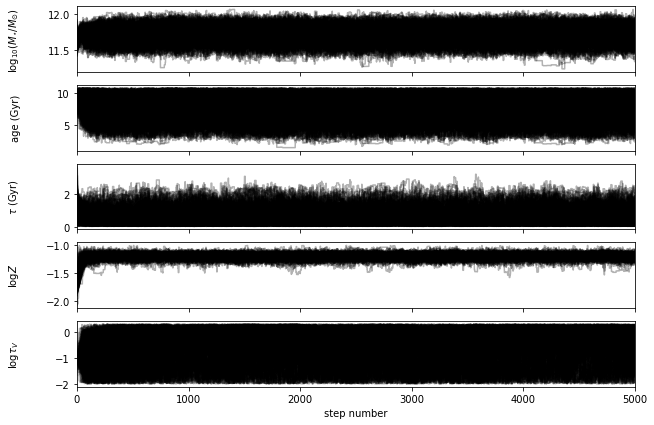

In [47]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

ndim = 5

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");



In [48]:
samples.shape

(5000, 200, 5)

In [49]:
flat_samples = samples[2000::200, :, :].reshape((-1, 5))

flat_samples.shape

(3000, 5)

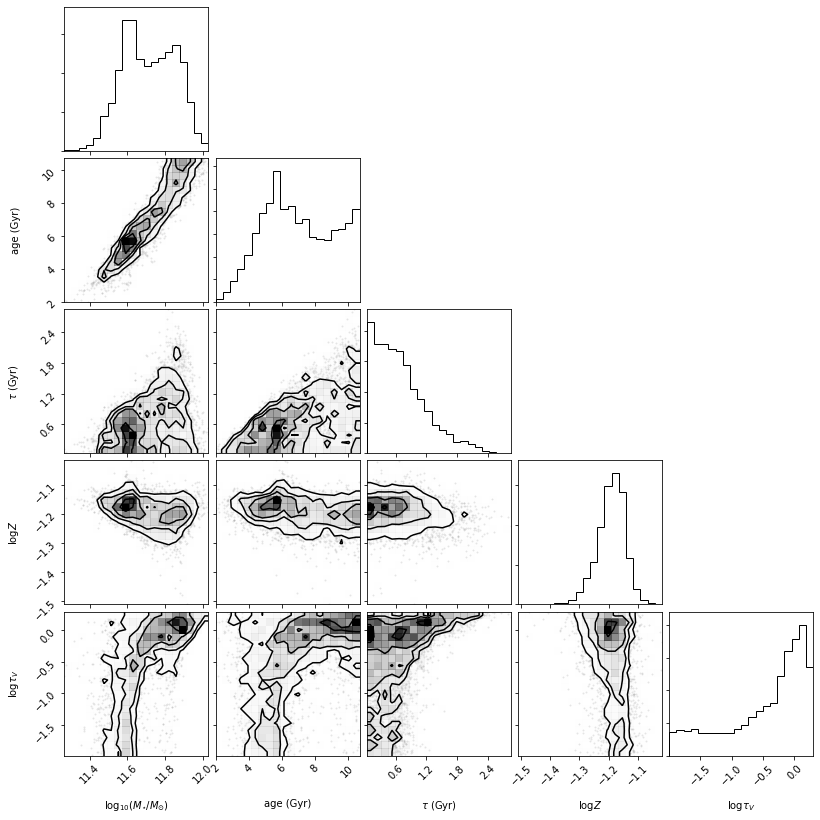

In [50]:
import corner

corner.corner(flat_samples, labels=labels);

In [51]:
low, med, high = np.percentile(flat_samples[:, 0], q=[16, 50, 84])

print('Stellar mass: {:.2f} + {:.2f} - {:.2f}'.format(med, high-med, med-low))

Stellar mass: 11.71 + 0.16 - 0.13


## Dependence of stellar mass on $H_0$

Text(0, 0.5, '$M_{\\star}$')

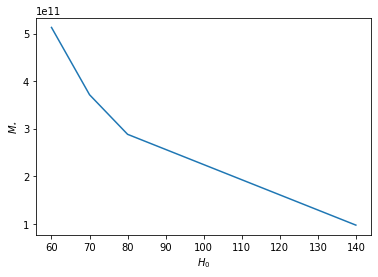

In [9]:
# the following values are obtained by running the above cells for different H_0 values
H0 = [60, 70, 80, 140]
log_M_star = np.array([11.71, 11.57, 11.46, 10.99])

plt.plot(H0, 10**log_M_star)

plt.xlabel(r'$H_0$')
plt.ylabel(r'$M_{\star}$');